# Randomized Prior Functions for Deep Reinforcement Learning
This is a PyTorch re-implementation of the code accompanying the paper
[Randomized Prior Functions for Deep Reinforcement Learning](https://arxiv.org/abs/1806.03335)
by Yuji Kanagawa(github: @kngwyu).

Plese see the
[author's website](https://sites.google.com/corp/view/randomized-prior-nips-2018/home)
for detail.

**Caveats**

I left almost all documents in this notebook as is.
So please take care that 'we' in this notebook refers not me, but the authors! :)

## 0. Outline

This notebook serves to accompany the 2018 NIPS paper ["Random Prior Functions for Deep Reinforcement Learning"](https://arxiv.org/abs/1806.03335).

The goal of this notebook is to:
- Provide some simple + clear example code.
- Help build some intuition for the proposed methods.
- Reproduce some of the results from the paper!

We hope this is a useful resource to accompany our paper!

## 1. Loading / setup

In [ ]:
#@title Install dependencies (only run this once)
! pip install pandas
! pip install plotnine
! pip install pytorch

In [2]:
#@title Imports
from abc import ABC, abstractmethod
import collections
import copy
import functools
import numpy as np
import pandas as pd
import plotnine as gg

import torch
from torch import nn
from torch.nn import functional as F

from IPython.display import clear_output
from matplotlib import pyplot as plt

from typing import Any, Callable, Dict, Iterable, List, NamedTuple, Optional, Tuple

# Plotnine themes
gg.theme_set(gg.theme_bw(base_size=16, base_family='serif'))
gg.theme_update(figure_size=(12, 8), panel_spacing_x=0.5, panel_spacing_y=0.5)

In [3]:
#@title PyTorch utilities
DEVICE = torch.device("cpu")  # You can also use GPU by cuda:0

def tensor(arr, dtype=torch.float32):
    return torch.tensor(arr, device=DEVICE, dtype=dtype)


def make_mlp(
    hidden_sizes: List[int],
    in_dim: int = 1,
    out_dim: int = 1,
    activator: Callable[[], nn.Module] = lambda : nn.SELU(inplace=True),
) -> None:
    modules = []
    dims = [in_dim] + hidden_sizes + [out_dim]
    for i in range(len(dims) - 1):
        linear = nn.Linear(dims[i], dims[i + 1])
        # TruncatedNormal is use in author's code, but this also works well
        nn.init.orthogonal_(linear.weight)
        nn.init.zeros_(linear.bias)
        modules.append(linear)
        if i < len(hidden_sizes):
            modules.append(activator())
    return nn.Sequential(*modules)

In [4]:
#@title Make toy 1D dataset for regression problems
def generate_data(
    n_data: int, x_scale: float = 2.0, std_dev: float = 2.0
) -> pd.DataFrame:
    x = np.linspace(-x_scale, x_scale, n_data)
    y = x + std_dev * np.random.randn(n_data)

    return pd.DataFrame({"x_train": x, "y_train": y})

np.random.seed(10)
DATA = generate_data(10)

Then let's check our data.

In [5]:
DATA

,x_train,y_train
0,-2.000000,0.663173
1,-1.555556,-0.124998
2,-1.111111,-4.201912
3,-0.666667,-0.683434
4,-0.222222,1.020450
5,0.222222,-1.217949
6,0.666667,1.197690
7,1.111111,1.328208
8,1.555556,1.564138
9,2.000000,1.650800


## 2. Randomized prior functions

"Prior networks" break down the function you are learning into:

\begin{equation}
Q_{\theta}(x) = \underbrace{f_\theta(x)}_{\text{trainable}} + \overbrace{\beta}^{\text{scaling}} \underbrace{p(x)}_{\text{prior}}. \tag{1}
\end{equation}

In this section we visualize the effects of training $f_\theta$ = (20, 20)-MLP  but with different choices of prior function $p$.

We will see that, given a flexible enough architecture $f$, for any $p$:
- The resultant $Q=f+p$ will be able to fit all of the observed data $(x,y)$.
- Away from the training data, generalization will be impacted by the interaction of $f$ with $p$.

As such, we say that $p$ plays a role similar to a "prior" in Bayesian inference: it controls how the agent generalizes in areas *without* data... whereas regions *with* data are still perfectly able to fit their observations.
In fact, this superficial similarity can be made much more rigorous for the simple case of linear regression.
For more on this connection please see Section 3 of [our paper](https://arxiv.org/abs/1806.03335)!


In [6]:
#@title ModelWithPrior + training routine
class ModelWithPrior(nn.Module):
    def __init__(
        self, 
        model_nn: nn.Module,
        prior_nn: nn.Module,
        prior_scale=0.1
    ) -> None:
        super().__init__()
        self.model_nn = model_nn
        self.prior_nn = prior_nn
        self.prior_scale = prior_scale
        self.to(DEVICE)
        
    def parameters(self) -> Iterable[nn.Module]:
        return self.model_nn.parameters()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        m_out = self.model_nn(x)
        with torch.no_grad():
            p_out = self.prior_nn(x)
        return m_out + p_out.mul(self.prior_scale), m_out, p_out
    
def train_prior_model(
    data: pd.DataFrame,
    prior: nn.Module,
    prior_label: str,
    hidden_sizes: List[int] = [20, 20],
    prior_scale: float = 1.,
    num_epochs: int = 100,
    plot_scale: float = 3.,
) -> pd.DataFrame:
    dims = [1] + hidden_sizes + [1]
    model = make_mlp(hidden_sizes, in_dim=1, out_dim=1)
    model_with_prior = ModelWithPrior(model, prior, prior_scale)
    
    opt = torch.optim.Adam(model_with_prior.parameters(), lr=5e-2)
    
    x_train = tensor(data['x_train'].values).view(-1, 1)
    y_train = tensor(data['y_train'].values).view(-1, 1)
    for _ in range(num_epochs):
        res, _, _ = model_with_prior(x_train)
        loss = F.mse_loss(res, y_train)
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    x_eval = np.linspace(-plot_scale, plot_scale, 1000)
    x_eval_torch = tensor(x_eval).view(-1, 1)
    with torch.no_grad():
        ymp, ym, yp = model_with_prior(x_eval_torch)
        
    return pd.DataFrame({
        'x': x_eval,
        'prior': prior_scale * yp.cpu().numpy().squeeze(),
        'model': ym.cpu().numpy().squeeze(),
        'model_with_prior': ymp.cpu().numpy().squeeze(),
        'prior_label': prior_label,
    })

We now  perform a simple experiment:
1. Fix a dataset of training data $(x,y)$
2. Initialize a prior function $p$.
3. Fit $Q_\theta = f_\theta + p$ to this data by optimizing $\theta$.

The following plots demonstrate how the prior function alters behaviour:
- Training data in **black** points $(x,y)$.
- Trainable function $f$ is the **dashed** line.
- Fixed (untrainable) prior function $p$ in <font color='blue'>**blue**</font>.
- Resultant prediction $Q = f + p$ in <font color='red'>**red**</font>.

The plots show that, for different choices of prior function:
- The neural network can still fit the data at observed data points $(x,y)$.
- The generalization behaviour away from the data is different for different choices of $p$.


In [7]:
#@title Train and evaluate
PRIOR_SCALE = 2.

PRIORS = {
    '$p(x)=0$': lambda x: torch.zeros_like(x),
    r'$p(x)={prior}(\exp(|x|) - 1)$'.format(prior=PRIOR_SCALE): lambda x: x.abs().exp().sub(-1.0) * PRIOR_SCALE,
    r'$p(x)={prior}$sin$(3x)$'.format(prior=PRIOR_SCALE): lambda x: torch.sin(x * 3) * PRIOR_SCALE,
    r'$p(x)={prior}(1 - x^2)$'.format(prior=PRIOR_SCALE): lambda x: (1 - x.pow(2)) * PRIOR_SCALE,
}

DF = pd.DataFrame()
PLOT_DATA = pd.DataFrame()
for label, prior in PRIORS.items():
    DF = DF.append(train_prior_model(
        DATA,
        prior,
        label,
        hidden_sizes=[20, 20],
        prior_scale=PRIOR_SCALE, 
        num_epochs=2000
    ))
    tmp_df = DATA.copy()
    tmp_df['prior_label'] = label
    PLOT_DATA = PLOT_DATA.append(tmp_df)

/home/yu/.local/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 432 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)
/home/yu/.local/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 470 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)
/home/yu/.local/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 106 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


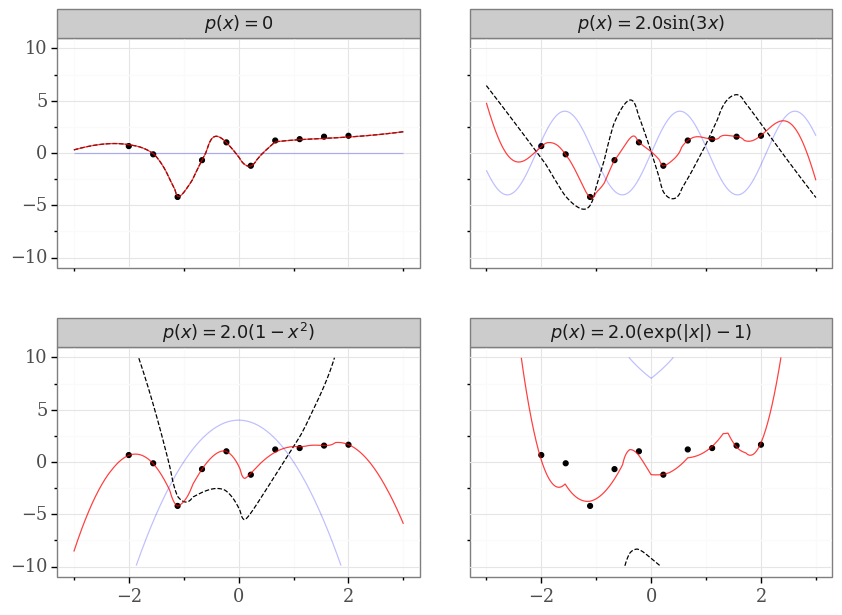

<ggplot: (8791911806933)>

In [8]:
#@title Plotting
p = (gg.ggplot(DF)
     + gg.geom_point(mapping=gg.aes(x='x_train', y='y_train'), data=PLOT_DATA)  # Training data
     + gg.geom_line(mapping=gg.aes(x='x', y='prior'), alpha=0.25, colour='blue')
     + gg.geom_line(mapping=gg.aes(x='x', y='model'), linetype='dashed')
     + gg.geom_line(mapping=gg.aes(x='x', y='model_with_prior'), alpha=0.75, colour='red')
     + gg.facet_wrap('prior_label', ncol=2)
     + gg.theme(figure_size=(10, 7))
     + gg.ylim(-10, 10)
     + gg.xlab('')
     + gg.ylab('')
    )
p

## 3. Approximate posterior distribution via ensemble

Section 2. outlines our approach to training a network with prior function.

In [our paper](https://arxiv.org/abs/1806.03335) we make the connection between:
1. Generating a single posterior sample
2. Training a network with randomized prior function

In fact, for linear networks, the two are precisely equivalent.


However, in many settings, a single posterior sample is not enough... we want to be able to approximate the *entire distribution* of posterior beliefs.
In this setting, our approach is very simple... just take multiple samples and use the resulting ensemble as an approximation to your posterior.

In [9]:
#@title EnsembleMLP + training routime

def make_mlps(
    hidden_sizes: List[int],
    in_dim: int,
    out_dim: int,
    num_ensembles: int,
    activator: Callable[[], nn.Module],
) -> nn.ModuleList:
    return nn.ModuleList(
        [
            make_mlp(hidden_sizes, in_dim=in_dim, out_dim=out_dim, activator=activator)
            for _ in range(num_ensembles)
        ]
    )


class EnsembleMLP(nn.Module):
    def __init__(
        self,
        hidden_sizes: List[nn.Module],
        num_ensembles: int,
        in_dim: int = 1,
        out_dim: int = 1,
        activator: Callable[[], nn.Module] = lambda: nn.SELU(inplace=True),
    ) -> None:
        super().__init__()
        self.models = make_mlps(hidden_sizes, in_dim, out_dim, num_ensembles, activator)
        self.num_ensembles = num_ensembles
        self.to(DEVICE)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = [m(x) for m in self.models]
        return torch.cat(out, dim=1)

    
def train_ensemble_models(
    data: pd.DataFrame,
    hidden_sizes: List[int],
    num_ensembles: int,
    num_epochs: int = 100,
    plot_scale: float = 3.,
) -> pd.DataFrame:
    raw = EnsembleMLP(hidden_sizes, num_ensembles)
    prior = EnsembleMLP(hidden_sizes, num_ensembles)
    
    model = ModelWithPrior(raw, prior)
    opt = torch.optim.Adam(model.parameters(), lr=5e-2)
    
    n_data = len(data)
    n_eval = 1000
    x_train = tensor(data['x_train'].values).view(-1, 1)
    y_train = tensor(data['y_train'].values).view(-1, 1)
    y_train_rep = y_train.repeat(1, num_ensembles)
    # Train
    for _ in range(num_epochs):
        res, _, _ = model(x_train)
        loss = F.mse_loss(res, y_train_rep)
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    # Evaluate
    xs = np.expand_dims(np.linspace(-plot_scale, plot_scale, n_eval), 1)
    with torch.no_grad():
        ymp, ym, yp = model(tensor(xs))
        
    y_model = ym.cpu().numpy()
    y_prior = yp.cpu().numpy()
    
    # Dataframe of ensemble-aggregated predictions
    agg_df = pd.DataFrame(
        np.hstack([xs, y_model]),
        columns=['x'] +list(range(num_ensembles))
    )
    agg_df = agg_df.melt(['x'], value_name='y')
    agg_df = agg_df.groupby('x')['y'].agg([np.mean, np.std]).reset_index()
    agg_df['num_ensemble'] = num_ensembles
    agg_df['sample'] = y_model[:, 0]
    
    # Dataframe of prior / predictions per ensemble member
    model_df = pd.DataFrame(
        np.hstack([xs, y_model]), 
        columns=['x'] + list(range(1, num_ensembles + 1))
    )
    model_df = model_df.melt(['x'], var_name='ensemble_member', value_name='y')
    prior_df = pd.DataFrame(
        np.hstack([xs, y_prior]), 
        columns=['x'] + list(range(1, num_ensembles + 1))
    )
    prior_df = prior_df.melt(['x'], var_name='ensemble_member', value_name='prior')

    model_df['prior'] = prior_df['prior']
    model_df['model'] = model_df.y - model_df.prior

    return agg_df, model_df

To demonstrate this effect, we perform a very simple experiment:
- Random prior $p_k$ is a (20,20)-MLP according to standard Glorot initialization for $k=1,..,10$.
- Train $Q^k_\theta = f^k_\theta + p_k$ for $k=1,..,10$
- Use the resultant $\{Q^k\}$ as an approximation to the posterior.

In [10]:
#@title Train and evaluate
EPOCHS = 1000
HIDDEN_SIZES = [20, 20]

AGG_DF, MODEL_DF = train_ensemble_models(
    data=DATA, 
    hidden_sizes=HIDDEN_SIZES, 
    num_epochs=EPOCHS, 
    num_ensembles=10
)

### Visualizing ensemble diversity

The plots below visualize the resultant $Q, f, p$ for $k=1,..,10$.

You can see that all the functions fit the training data, but they do not generalize in exactly the same way.

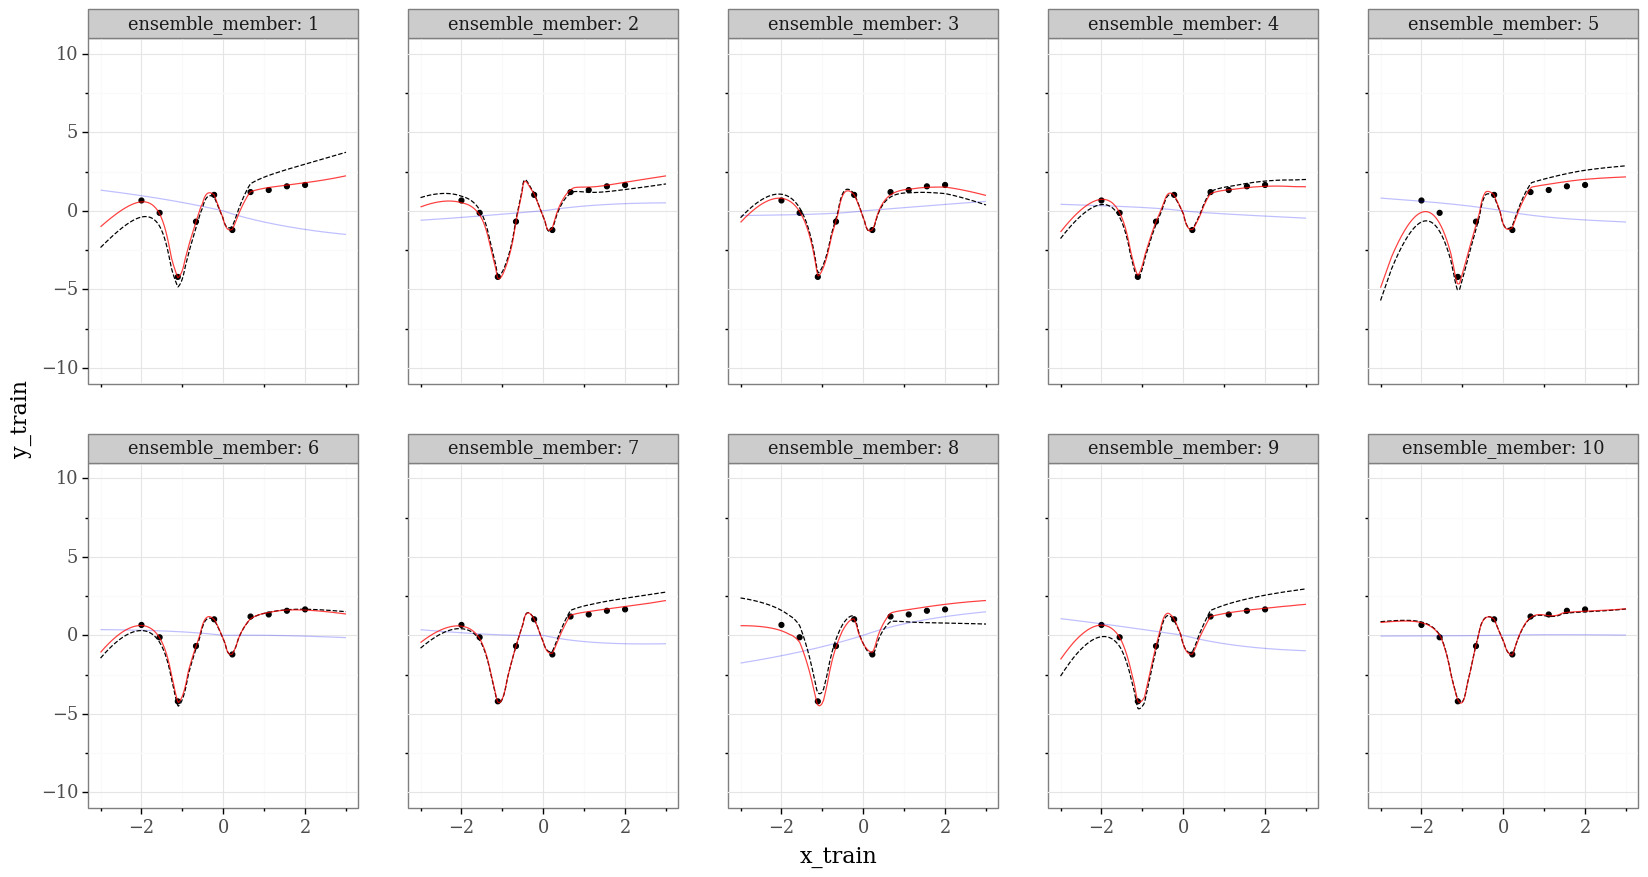

<ggplot: (8791923613909)>

In [11]:
#@title Plotting each trained network + prior
p = (gg.ggplot(MODEL_DF)
     + gg.geom_point(mapping=gg.aes(x='x_train', y='y_train'), data=DATA)  # Training data
     + gg.geom_line(mapping=gg.aes(x='x', y='prior'), alpha=0.25, colour='blue')
     + gg.geom_line(mapping=gg.aes(x='x', y='model'), linetype='dashed')
     + gg.geom_line(mapping=gg.aes(x='x', y='y'), alpha=0.75, colour='red')
     + gg.facet_wrap('ensemble_member', ncol=5, labeller='label_both')
     + gg.theme(figure_size=(20, 10))
     + gg.ylim(-10, 10)
    )
p

### Summarizing ensemble into approximate distribution

We can combine the ensemble predictions by taking the mean and standard deviation of predictions $\{Q^k(x)\}$ at each $x$.
- Training data $(x,y)$ are black dots.
- Blue line represents the mean prediction
- Shaded grey bands at $\pm 1, 2$ standard deviations.

We feel that, intuitively, this represents a reasonable approximation to posterior uncertainty.

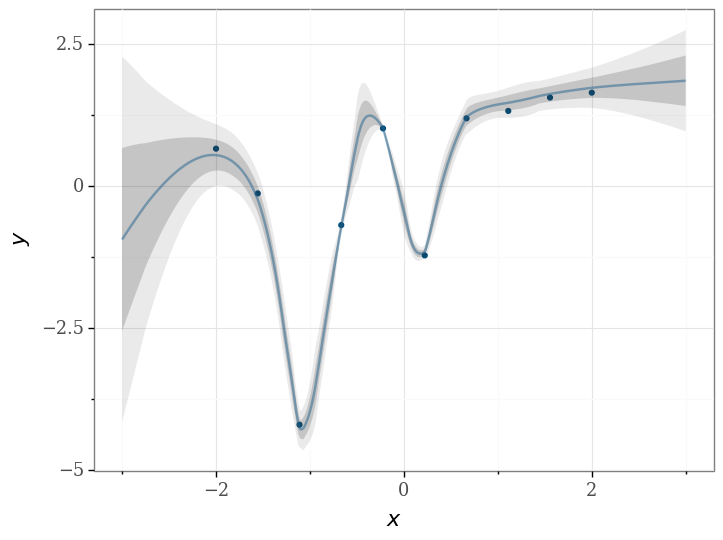

<ggplot: (8791869839393)>

In [12]:
#@title Plotting the ensemble as a whole
p = (gg.ggplot(AGG_DF)
     + gg.geom_point(gg.aes('x_train', 'y_train'), data=DATA, colour='#034e7b')
     + gg.geom_line(gg.aes('x', 'mean'), colour='#1f77b4', size=1, alpha=0.5)
    #  + gg.geom_line(gg.aes('x', 'sample'), colour='#d62728', size=1, alpha=0.5)
     + gg.geom_ribbon(gg.aes('x', 'std', ymin='mean - std', ymax='mean + std'), alpha=0.2)
     + gg.geom_ribbon(gg.aes('x', 'std', ymin='mean - 2 * std', ymax='mean + 2 * std'), alpha=0.1)
     + gg.theme(figure_size=(8, 6))
     + gg.labs(x=r'$x$', y=r'$y$')
    )
p

### Adding extra noise to the data

In problems with observation noise, the ensemble procedure above will fit to every data point exactly... and this may not be appropriate!

Analogous to the Bayesian derivation of [Section 3](https://arxiv.org/abs/1806.03335), we should add noise to the targets $y$ similar to the type of noise we expect to see with our data.
- If we know the scale of the noise, we can simply add noise in that family.
- If we do not know the noise distribution, bootstrapping offers a non-parametric way to estimate it.
https://en.wikipedia.org/wiki/Bootstrapping_(statistics)

However, once you have enough data, the effects of bootstrapping (or adding noise) will wash out eventually.

Our next series of plots repeats the ensemble procedure with bootstrapping *and* prior functions.

In [13]:
#@title Training a bootstrap ensemble

def train_ensemble_models_bootstrap(
    data: pd.DataFrame,
    hidden_sizes: List[int],
    num_ensembles: int,
    num_epochs: int = 1000,
    plot_scale: float = 3.
) -> pd.DataFrame:
    ensemble_data = []
    training_data = []
    for k in range(num_ensembles):
        boot_data = data.sample(n=len(data), replace=True)
        prior = make_mlp(hidden_sizes + [1])
        prior_label = 'ensemble member {}'.format(k)
    
        model_df = train_prior_model(
            boot_data, 
            prior, 
            prior_label,
            hidden_sizes,
            num_epochs=num_epochs
        )
        ensemble_data.append(model_df)
    
        boot_data['prior_label'] = prior_label
        training_data.append(boot_data)
    return pd.concat(ensemble_data), pd.concat(training_data)

BOOT_DF, BOOT_DATA = train_ensemble_models_bootstrap(DATA, [20, 20], 10)

/home/yu/.local/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 72 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)
/home/yu/.local/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 102 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


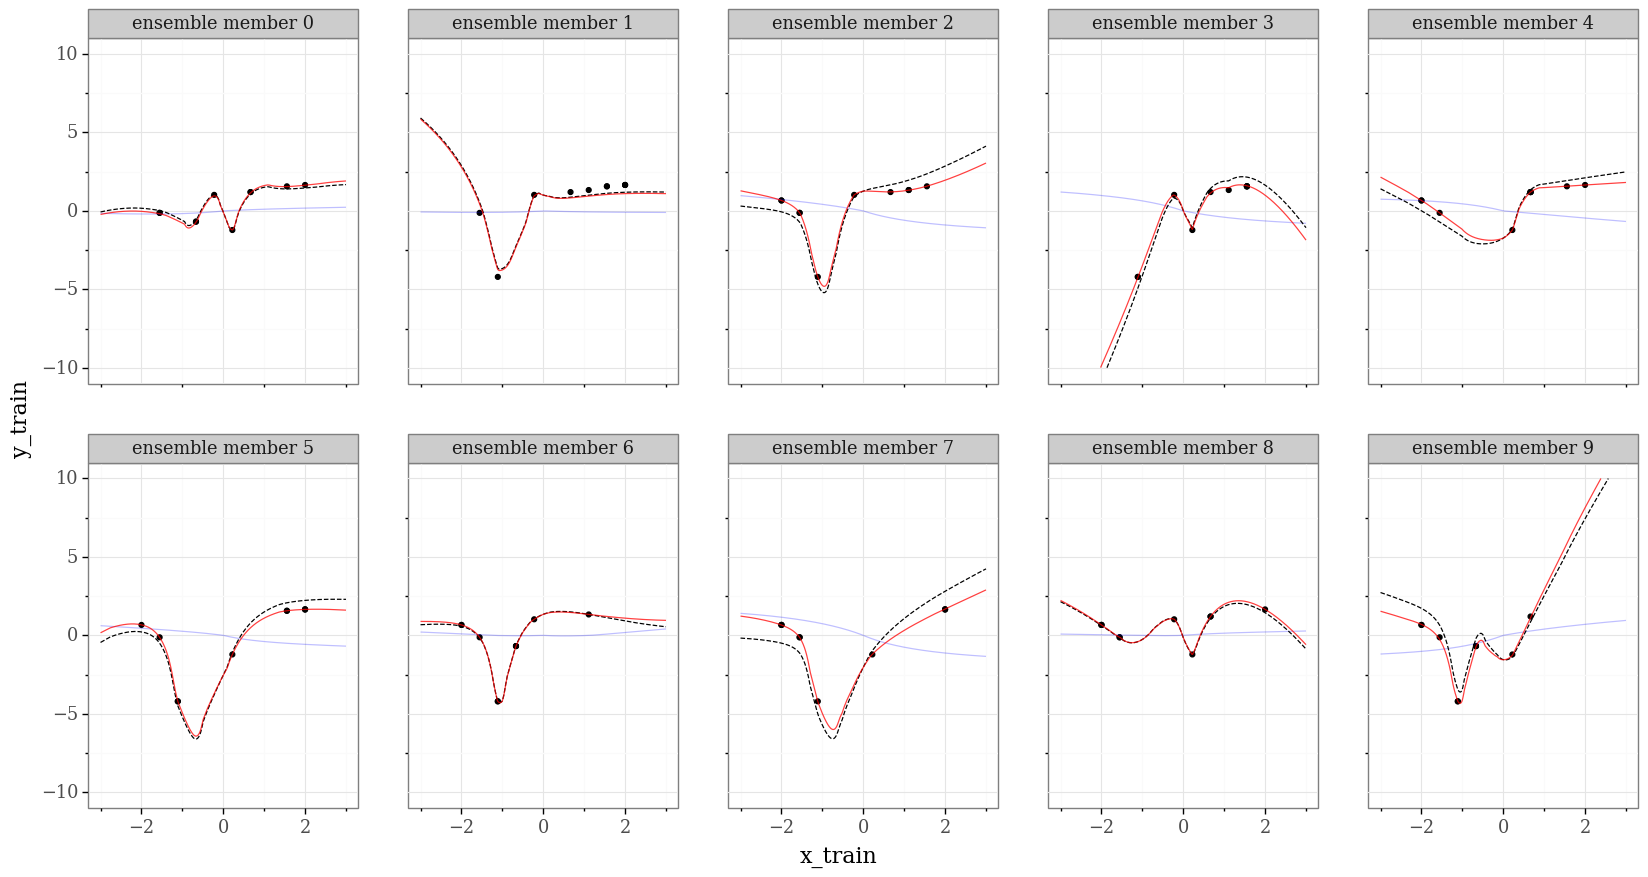

<ggplot: (8791877944865)>

In [14]:
#@title Plotting each (bootstrapped) ensemble member
p = (gg.ggplot(BOOT_DF)
     + gg.geom_point(mapping=gg.aes(x='x_train', y='y_train'), data=BOOT_DATA)  # Training data
     + gg.geom_line(mapping=gg.aes(x='x', y='prior'), alpha=0.25, colour='blue')
     + gg.geom_line(mapping=gg.aes(x='x', y='model'), linetype='dashed')
     + gg.geom_line(mapping=gg.aes(x='x', y='model_with_prior'), alpha=0.75, colour='red')
     + gg.facet_wrap('prior_label', ncol=5)
     + gg.theme(figure_size=(20, 10))
     + gg.ylim(-10, 10)
    )
p

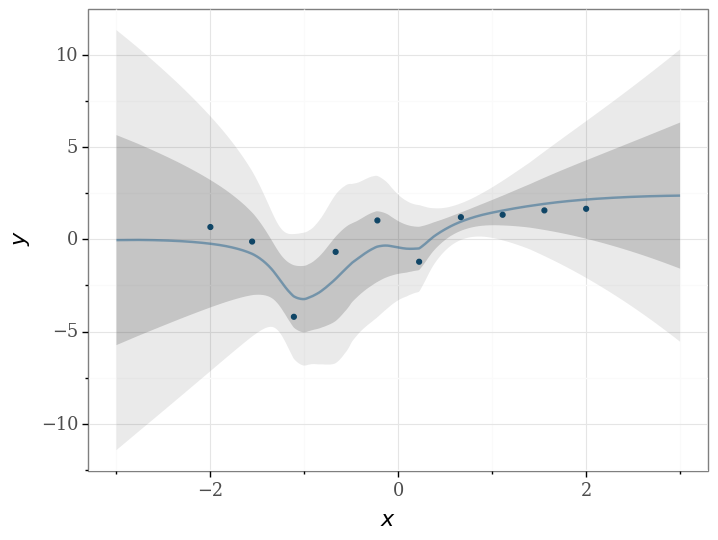

<ggplot: (8791911314129)>

In [15]:
#@title Plotting the ensemble as a whole with bootstrapping
AGG_BOOT = (
    BOOT_DF.groupby('x')['model_with_prior']
           .agg([np.mean, np.std])
           .reset_index()
)

p = (gg.ggplot(AGG_BOOT)
     + gg.geom_point(gg.aes('x_train', 'y_train'), data=DATA, colour='#034e7b')
     + gg.geom_line(gg.aes('x', 'mean'), colour='#1f77b4', size=1, alpha=0.5)
    #  + gg.geom_line(gg.aes('x', 'sample'), colour='#d62728', size=1, alpha=0.5)
     + gg.geom_ribbon(gg.aes('x', 'std', ymin='mean - std', ymax='mean + std'), alpha=0.2)
     + gg.geom_ribbon(gg.aes('x', 'std', ymin='mean - 2 * std', ymax='mean + 2 * std'), alpha=0.1)
     + gg.theme(figure_size=(8, 6))
     + gg.labs(x=r'$x$', y=r'$y$')
    )
p

## 4. RL on a chain domain


The sections above introduce "randomized prior functions" via simple 1D regression problems. **However, our principle interest is in driving efficient exploration for reinforcement learning.** If we can quanitify the agent's uncertainty over the value, then we can prioritize potentially informative policies.
To highlight the importance of efficient exploration we investigate performance on a series of chain-like domains designed to highlight the need for *deep exploration*:
- [Deep exploration](https://arxiv.org/abs/1703.07608) refers to an advanced form of exploration that is necessary for efficient learning in reinforcement learning.
- An agent that employs deep exploration can take an action in order to reach a potentially-informative future state, even if the immediate action is not itself informative.
- The idea of "deep exploration" is not new, and was identified by [Kearns and Singh, (2002)](https://www.cis.upenn.edu/~mkearns/papers/KearnsSinghE3.pdf) as an essential ingredient for polynomial learning in reinforcement learning.

### 4.1 "Deep sea" environment

We now describe the family of chain-like environments we call "deep sea":
- Input state is an $N x N$ grid.
- Observations are 1-hot, and the agent begins in top left square.
- Actions are $\{0, 1\}$, but the mapping to "left" and "right" is a fixed random mapping per state.
- Every timestep the agent falls one row down.
- Action "left" receives a reward of 0, action "right" reward of $-\frac{0.01}{N}$.
- If the agent makes it to the bottom far right then it receives an extra reward of $1$.

Note that there is a single policy with episodic return $0.99$, a single policy with return $0$ and all other policies have negative return.
Algorithms that do not perform deep exploration will require $O(2^N)$ episodes to find the rewarding policy, but algorithms that *do* perform deep exploration can learn much faster... in fact, with a tabular representation, we would expect "randomized least-squares value iteration" [(RLSVI)](https://arxiv.org/pdf/1703.07608.pdf) to learn in O(N^3) episodes.
Our implementation of bootstrapped ensemble + randomized prior represents a practical neural network implementation of RLSVI.

For more information on this environment/setup please see:
- Section 4 of our NIPS paper [randomized prior functions for deep reinforcement learning](https://arxiv.org/pdf/1806.03335.pdf)
- JMLR paper [deep exploration via randomized value functions](https://arxiv.org/pdf/1703.07608.pdf)

In [16]:
#@title Define the _Deep Sea_ environment

class TimeStep(NamedTuple):
    observation: np.ndarray
    reward: float
    is_terminal: bool
        
    @property
    def pcont(self):
        return 1.0 - self.is_terminal


class DeepSea:
    def __init__(self, size: int, seed: int = None, randomize: bool = True):

        self._size = size
        self._move_cost = 0.01 / size
        self._goal_reward = 1.0

        self._column = 0
        self._row = 0

        if randomize:
            rng = np.random.RandomState(seed)
            self._action_mapping = rng.binomial(1, 0.5, size)
        else:
            self._action_mapping = np.ones(size)

        self._reset_next_step = False

    def step(self, action: int) -> TimeStep:
        if self._reset_next_step:
            return self.reset()
        # Remap actions according to column (action_right = go right)
        action_right = action == self._action_mapping[self._column]

        # Compute the reward
        reward = 0.0
        if self._column == self._size - 1 and action_right:
            reward += self._goal_reward

        # State dynamics
        if action_right:  # right
            self._column = np.clip(self._column + 1, 0, self._size - 1)
            reward -= self._move_cost
        else:  # left
            self._column = np.clip(self._column - 1, 0, self._size - 1)

        # Compute the observation
        self._row += 1
        if self._row == self._size:
            observation = self._get_observation(self._row - 1, self._column)
            self._reset_next_step = True
            return TimeStep(observation, reward, is_terminal=True)
        else:
            observation = self._get_observation(self._row, self._column)
            return TimeStep(observation, reward, is_terminal=False)

    def reset(self) -> TimeStep:
        self._reset_next_step = False
        self._column = 0
        self._row = 0
        observation = self._get_observation(self._row, self._column)

        return TimeStep(observation, reward=None, is_terminal=False)

    def _get_observation(self, row, column) -> np.ndarray:
        observation = np.zeros(shape=(self._size, self._size), dtype=np.float32)
        observation[row, column] = 1

        return observation

    @property
    def obs_shape(self) -> Tuple[int]:
        return self._size, self._size

    @property
    def num_actions(self) -> int:
        return 2

    @property
    def optimal_return(self) -> float:
        return self._goal_reward - self._move_cost
    
    @staticmethod
    def _get_user_action():
        action = input('Action ([a] = 0, [d] = 1, [q] = Quit): ')
        if action == 'a':
            action = 0
        elif action == 'd':
            action = 1
        elif action == 'q':
            return -1
        else:
            print('Bad action! Must be `a` or `d` or `q`.')
            return DeepSea._get_user_action()
        return action

    def play(self):
        step = env.reset()
        episode_return = 0
        while not step.is_terminal:
            plt.grid(False)
            ax = plt.gca()
            # ax.set_axis_off()
            # Major ticks
            ax.set_xticks(np.arange(0, 11, 1))
            ax.set_yticks(np.arange(0, 11, 1))

            # Labels for major ticks
            ax.set_xticklabels(np.arange(1, 11, 1))
            ax.set_yticklabels(np.arange(1, 11, 1))

            # Minor ticks
            ax.set_xticks(np.arange(-0.5, 11, 1), minor=True)
            ax.set_yticks(np.arange(-0.5, 11, 1), minor=True)

            # Gridlines based on minor ticks
            ax.grid(which="minor", color="k", linestyle="-", linewidth=1)
            plt.imshow(step.observation, interpolation="none")
            plt.show()
            a = self._get_user_action()
            clear_output(False)
            if a == -1:
                break  # User quit
            step = env.step(a)
            episode_return += step.reward
            print("Episode return: {}".format(episode_return))
        ax.set_visible(False)

### 4.1.1 Play "deep sea" for yourself

Here we spin up an instance of the environment:
- Set the problem size $N$
- Use randomized actions (or not)
- Seed (for randomized action selection)

Playing this game without randomized actions the optimal policy is just to do action "d" = "right" each timestep.

If you do this with randomized action selection, which is what our agent sees, you'll see that this is not a trivial problem even for $N=10$.

In [17]:
#@title Play _Deep Sea_
deep_sea_size = 10  #@param {type:"integer"}
randomized_actions = True  #@param{type:"boolean"}

env = DeepSea(size=deep_sea_size, randomize=randomized_actions, seed=1)
env.play()

### 4.2 RL agent

In this section we implement a basic DQN and Bootstrapped DQN + prior function.
- Train each agent on N=20 deep sea problem
- Any dithering strategy for exploration will take around $2^N \simeq$ 1e6 for $N=20$.
- We find that bootstrapped DQN + prior functions typically solves this problem in around 2000 episodes!

In [18]:
#@title Simple circular replay buffer with uniform sampling.

class Replay:
    """A simple ring buffer with uniform sampling."""

    def __init__(self, capacity: int):
        self._data = collections.deque(maxlen=capacity)
        self._capacity = capacity

    def add(self, *args) -> None:
        self._data.append(args)

    def sample(self, batch_size: int = 1) -> Tuple[np.ndarray]:
        """Returns a transposed/stacked minibatch. Each array has shape [B, ...]."""
        indices = np.random.randint(len(self._data), size=batch_size)
        return [self._data[idx] for idx in indices]

    def __len__(self) -> int:
        return len(self._data)

In [19]:
#@title Basic Q-networks

class QNetwork(ABC):
    @property
    @abstractmethod
    def num_actions(self) -> int:
        pass
    
    @abstractmethod
    def q_s(self, obs: torch.Tensor) -> torch.Tensor:
        pass
    
    def q_s_a(self, obs: torch.Tensor, action: np.ndarray) -> torch.Tensor:
        batch_size = obs.size(0)
        return self.q_s(obs)[np.arange(batch_size), action]
    
    def q_target(
        self,
        next_obs: torch.Tensor,
        reward: torch.Tensor,
        pcont: torch.Tensor,
        discount: float,
    ) -> torch.Tensor:
        q_next, _ = self.q_s(next_obs).max(axis=-1)
        return reward + q_next.mul_(pcont).mul_(discount)
    
    def reset(self):
        pass
    
    def greedy(self, state: torch.Tensor) -> torch.Tensor:
        return self.q_s(state).squeeze().argmax().item()
    
    @torch.no_grad()
    def eps_greedy(self, epsilon: float, step: TimeStep) -> int:
        if np.random.rand() < epsilon:
            return np.random.randint(self.num_actions)
        else:
            return self.greedy(tensor(step.observation).view(1, -1))
        
    
class MLPQNetwork(nn.Module, QNetwork):
    def __init__(
        self,
        hidden_size: List[int],
        state_dim: int,
        num_actions: int,
        activator: Callable[[], nn.Module] = lambda: nn.ReLU(inplace=True),
    ):
        super().__init__()
        self.model = make_mlp(
            hidden_size, in_dim=state_dim, out_dim=num_actions, activator=activator
        )
        self._num_actions = num_actions
        self.to(DEVICE)
        
    @property
    def num_actions(self) -> int:
        return self._num_actions

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)
        
    def q_s(self, state: torch.Tensor) -> torch.Tensor:
        return self(state)

### 4.2.1 Training basic DQN

- Here we present a basic DQN training loop
- DQN with $\epsilon$-greedy actions cannot solve $N=20$ problem

**NOTE(by kngwyu)**
Since updates are episodic, we do not use a target network here.

In [20]:
#@title Training routine

def train_dqn(
    deepsea_size: int = 20,
    max_episodes: int = 6000,
    epsilon: float = 0.1,
    discount: float = 0.99,
    batch_size: int = 128,
    replay_capacity: int = 100000,
    hidden_sizes: List[int] = [20],
    net_fn: Callable[[List[int], int, int], QNetwork] = MLPQNetwork,
    algorithm: str = "dqn",
) -> None:
    # Make environment
    env = DeepSea(size=20, randomize=True)
    # Networks.
    obs_shape = np.prod(env.obs_shape)
    num_actions = env.num_actions
    q_net = net_fn(hidden_sizes, obs_shape, num_actions)
    optim = torch.optim.Adam(q_net.parameters())
    
    # Replay buffer.
    replay = Replay(capacity=replay_capacity)

    total_return = 0.0
    optimal_return = 0.99
    results = []
    for episode in range(max_episodes):
        timestep = env.reset()
        obs = timestep.observation.flatten()
        episode_return = 0.0
        q_net.reset()
        while not timestep.is_terminal:
            act = q_net.eps_greedy(epsilon, timestep)
            # Agent-environment interaction.
            timestep = env.step(act)
            episode_return += timestep.reward
            new_obs = timestep.observation.flatten()
            # Add to replay.
            replay.add(obs, act, new_obs, timestep.reward, timestep.pcont)
            obs = new_obs

        # After each episode, do one SGD step and update the target network.
        batch = replay.sample(batch_size)
        obs, a, new_obs, r, pcont = map(np.asarray, zip(*batch))
        with torch.no_grad():
            q_target = q_net.q_target(tensor(new_obs), tensor(r), tensor(pcont), discount)
        q_current = q_net.q_s_a(tensor(obs), a)
        loss = F.mse_loss(q_current, q_target)
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Compute running total return/regret.
        total_return += episode_return
        optimal_return += 0.99
        regret = optimal_return - total_return

        # Logging.
        results.append(
            {"episode": episode, "regret": regret, "algorithm": algorithm}
        )
        if episode % 100 == 0 or episode == max_episodes - 1:
            print(
                "Episode: {}.\tTotal return: {:.2f}.\tRegret: {:.2f}.".format(
                    episode, total_return, regret
                )
            )

    return pd.DataFrame(results)

In [21]:
#@title Train DQN on _Deep Sea_
df = train_dqn()

Episode: 0.	Total return: -0.01.	Regret: 1.99.
Episode: 100.	Total return: -0.58.	Regret: 101.56.
Episode: 200.	Total return: -1.14.	Regret: 201.12.
Episode: 300.	Total return: -1.62.	Regret: 300.60.
Episode: 400.	Total return: -2.04.	Regret: 400.02.
Episode: 500.	Total return: -2.52.	Regret: 499.50.
Episode: 600.	Total return: -2.88.	Regret: 598.86.
Episode: 700.	Total return: -3.23.	Regret: 698.21.
Episode: 800.	Total return: -3.52.	Regret: 797.50.
Episode: 900.	Total return: -3.78.	Regret: 896.76.
Episode: 1000.	Total return: -4.40.	Regret: 996.38.
Episode: 1100.	Total return: -4.98.	Regret: 1095.96.
Episode: 1200.	Total return: -5.39.	Regret: 1195.37.
Episode: 1300.	Total return: -5.74.	Regret: 1294.72.
Episode: 1400.	Total return: -6.06.	Regret: 1394.04.
Episode: 1500.	Total return: -6.39.	Regret: 1493.37.
Episode: 1600.	Total return: -6.58.	Regret: 1592.56.
Episode: 1700.	Total return: -6.71.	Regret: 1691.69.
Episode: 1800.	Total return: -6.81.	Regret: 1790.79.
Episode: 1900.	Tot

### 4.2.2 [Optinal] Training ensemble DQN

In [22]:
#@title Prior&Ensemble Q-Network

class EnsembleQNetwork(nn.Module, QNetwork):
    def __init__(
        self,
        hidden_size: List[int],
        state_dim: int,
        num_actions: int,
        num_ensembles: int = 10,
        activator: Callable[[], nn.Module] = lambda: nn.ReLU(inplace=True),
    ):
        super().__init__()
        self.models = make_mlps(
            hidden_size, state_dim, num_actions, num_ensembles, activator
        )
        self.active_head = 0
        self.num_ensembles = num_ensembles
        self._num_actions = num_actions
        self.to(DEVICE)
        
    @property
    def num_actions(self) -> int:
        return self._num_actions

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.stack([m(x) for m in self.models], dim=1)

    def q_s(self, state: torch.Tensor) -> torch.Tensor:  # [B, K, A]
        return self(state)

    def q_s_a(self, state: torch.Tensor, action: np.ndarray) -> torch.Tensor:
        batch_size = state.size(0)
        action = tensor(action, dtype=torch.long)
        one_hot = F.one_hot(action, num_classes=self._num_actions)
        qs = self(state)
        return torch.einsum("bka,ba->bk", qs, one_hot.float())
    
    def q_target(
        self,
        next_obs: torch.Tensor,
        reward: torch.Tensor,
        pcont: torch.Tensor,
        discount: float,
    ) -> torch.Tensor:
        q_next, _ = self.q_s(next_obs).max(axis=-1)
        return reward.view(-1, 1) + q_next * pcont.view(-1, 1) * discount

    def reset(self):
        self.active_head = np.random.randint(self.num_ensembles)

    def greedy(self, state: torch.Tensor) -> torch.Tensor:
        return self(state)[:, self.active_head, :].squeeze().argmax().item()

In [23]:
df = df.append(train_dqn(net_fn=EnsembleQNetwork, algorithm="bootdqn"))

Episode: 0.	Total return: -0.00.	Regret: 1.98.
Episode: 100.	Total return: -0.52.	Regret: 101.50.
Episode: 200.	Total return: -1.03.	Regret: 201.01.
Episode: 300.	Total return: -1.65.	Regret: 300.63.
Episode: 400.	Total return: -2.24.	Regret: 400.22.
Episode: 500.	Total return: -2.84.	Regret: 499.82.
Episode: 600.	Total return: -3.46.	Regret: 599.44.
Episode: 700.	Total return: -4.02.	Regret: 699.00.
Episode: 800.	Total return: -4.59.	Regret: 798.57.
Episode: 900.	Total return: -5.13.	Regret: 898.11.
Episode: 1000.	Total return: -5.69.	Regret: 997.67.
Episode: 1100.	Total return: -6.24.	Regret: 1097.22.
Episode: 1200.	Total return: -6.87.	Regret: 1196.85.
Episode: 1300.	Total return: -7.43.	Regret: 1296.42.
Episode: 1400.	Total return: -7.92.	Regret: 1395.90.
Episode: 1500.	Total return: -8.36.	Regret: 1495.34.
Episode: 1600.	Total return: -8.73.	Regret: 1594.71.
Episode: 1700.	Total return: -9.03.	Regret: 1694.01.
Episode: 1800.	Total return: -9.25.	Regret: 1793.23.
Episode: 1900.	Tot

### 4.2.3 Training ensemble DQN + prior function

- Simple implementation of ensemble DQN + random prior functions
- With default settings we solve $N=20$ in around 2000 episodes
- For more results, see [our paper](https://arxiv.org/pdf/1806.03335.pdf)

In [24]:
#@title Prior&Ensemble Q-Network

class PriorQNetwork(EnsembleQNetwork):
    def __init__(
        self,
        hidden_size: List[int],
        state_dim: int,
        num_actions: int,
        num_ensembles: int = 10,
        prior_scale: float = 10.0,
        activator: Callable[[], nn.Module] = lambda: nn.ReLU(inplace=True),
    ):
        nn.Module.__init__(self)
        self.model = make_mlps(
            hidden_size, state_dim, num_actions, num_ensembles, activator
        )
        self.prior = make_mlps(
            hidden_size, state_dim, num_actions, num_ensembles, activator
        )
        self._num_actions = num_actions
        self.prior_scale = prior_scale
        self.active_head = 0
        self.num_ensembles = num_ensembles
        self.to(DEVICE)
        
    def parameters(self) -> Iterable[nn.Module]:
        return self.model.parameters()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raw = torch.stack([m(x) for m in self.model], dim=1)
        with torch.no_grad():
            prior = torch.stack([m(x) for m in self.prior], dim=1)
        return raw + prior * self.prior_scale

In [25]:
df = df.append(train_dqn(net_fn=PriorQNetwork, algorithm="rpf"))

Episode: 0.	Total return: -0.01.	Regret: 1.99.
Episode: 100.	Total return: -0.51.	Regret: 101.49.
Episode: 200.	Total return: -1.00.	Regret: 200.98.
Episode: 300.	Total return: -1.51.	Regret: 300.49.
Episode: 400.	Total return: -2.06.	Regret: 400.04.
Episode: 500.	Total return: -2.65.	Regret: 499.63.
Episode: 600.	Total return: -3.28.	Regret: 599.26.
Episode: 700.	Total return: -3.99.	Regret: 698.97.
Episode: 800.	Total return: -4.71.	Regret: 798.69.
Episode: 900.	Total return: -5.45.	Regret: 898.44.
Episode: 1000.	Total return: -6.20.	Regret: 998.18.
Episode: 1100.	Total return: -6.94.	Regret: 1097.92.
Episode: 1200.	Total return: -7.67.	Regret: 1197.65.
Episode: 1300.	Total return: -8.41.	Regret: 1297.39.
Episode: 1400.	Total return: -9.21.	Regret: 1397.19.
Episode: 1500.	Total return: -9.99.	Regret: 1496.98.
Episode: 1600.	Total return: -10.78.	Regret: 1596.76.
Episode: 1700.	Total return: -11.56.	Regret: 1696.54.
Episode: 1800.	Total return: -12.29.	Regret: 1796.27.
Episode: 1900.	

### 4.2.4 Plotting results

- We see that ensemble DQN successfully solves the problem
- Learning in polynomial time demonstrates effective deep exploration

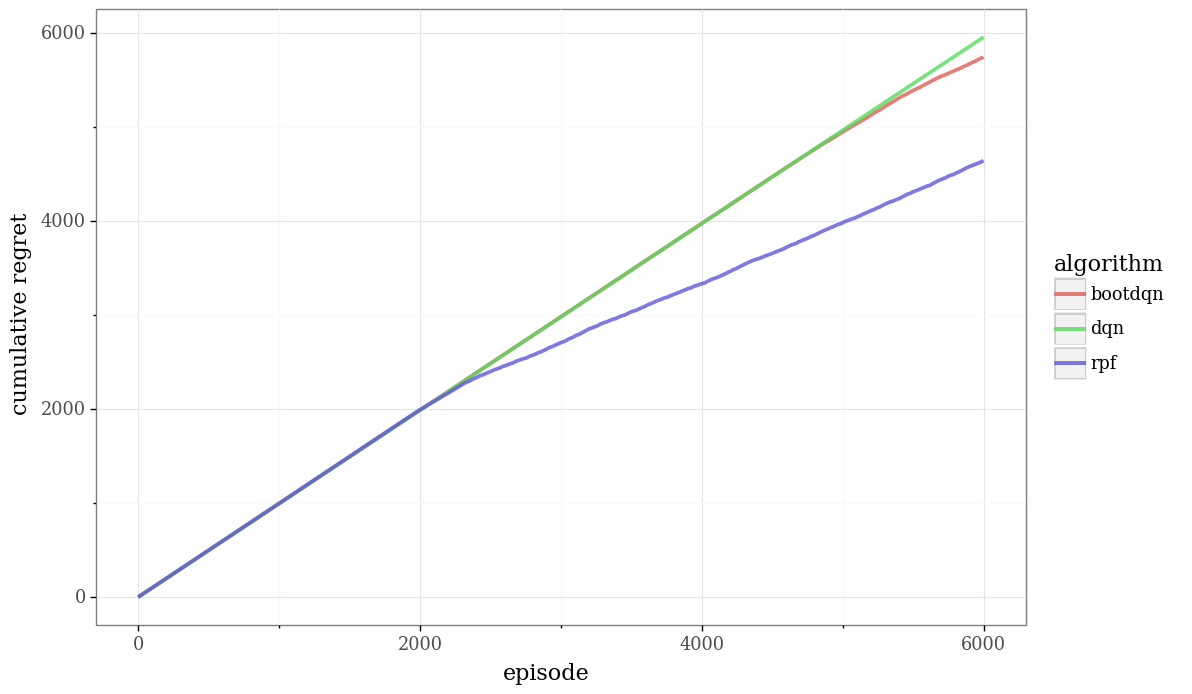

<ggplot: (8791911764221)>

In [26]:
#@title Plotting cumulative regret (RPF learns size=20 in ~= 2k episodes)

regret_plot = (
    gg.ggplot(df)
    + gg.aes(x="episode", y="regret", colour="algorithm")
    + gg.geom_line(size=1.5, alpha=0.8)
    + gg.ylab("cumulative regret")
)
regret_plot

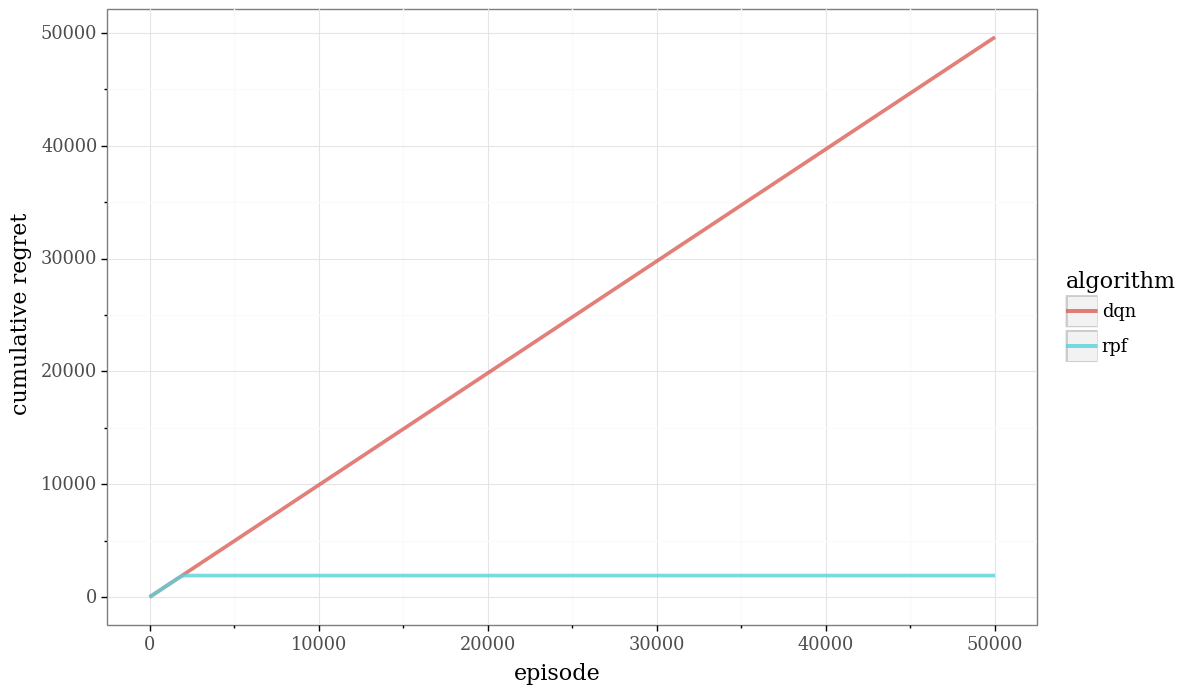

<ggplot: (8791911764221)>

In [27]:
#@title Plotting pre-trained data to 50k episodes performance difference is clear

# Loading in pretrained data from string.
import sys
from io import StringIO
DF_CSV = 'algorithm,episode,regret\ndqn,0,0.995\ndqn,100,100.50199999999985\ndqn,200,199.93850000000035\ndqn,300,299.45850000000127\ndqn,400,398.91200000000214\ndqn,500,498.22850000000307\ndqn,600,597.448000000004\ndqn,700,696.6745000000049\ndqn,800,796.1710000000057\ndqn,900,895.5035000000067\ndqn,1000,994.8240000000076\ndqn,1100,1094.1985000000084\ndqn,1200,1193.3065000000092\ndqn,1300,1292.4000000000103\ndqn,1400,1391.459500000011\ndqn,1500,1490.524000000012\ndqn,1600,1589.584000000013\ndqn,1700,1688.6395000000139\ndqn,1800,1787.7750000000149\ndqn,1900,1886.8435000000156\ndqn,2000,1985.9095000000166\ndqn,2100,2084.99350000001\ndqn,2200,2184.0809999999883\ndqn,2300,2283.2709999999665\ndqn,2400,2382.4824999999446\ndqn,2500,2481.6564999999227\ndqn,2600,2580.877999999901\ndqn,2700,2680.0369999998793\ndqn,2800,2779.1464999998575\ndqn,2900,2878.3164999998357\ndqn,3000,2976.2961374728284\ndqn,3100,3075.3620263241614\ndqn,3200,3174.276645827338\ndqn,3300,3275.859480445941\ndqn,3400,3374.7570916782356\ndqn,3500,3475.8367034854573\ndqn,3600,3573.5624587730395\ndqn,3700,3672.0266436413763\ndqn,3800,3771.3619753383637\ndqn,3900,3871.5478036634768\ndqn,4000,3971.0742228988415\ndqn,4100,4069.2636539938526\ndqn,4200,4169.397048208838\ndqn,4300,4268.3527444610045\ndqn,4400,4367.240519455234\ndqn,4500,4464.335601393114\ndqn,4600,4565.456050213399\ndqn,4700,4665.394290194531\ndqn,4800,4763.764728177627\ndqn,4900,4864.201834901016\ndqn,5000,4961.039400101862\ndqn,5100,5064.005519084016\ndqn,5200,5160.722792580067\ndqn,5300,5261.553941519752\ndqn,5400,5359.44298831027\ndqn,5500,5460.197091134784\ndqn,5600,5558.047656478276\ndqn,5700,5656.584610767494\ndqn,5800,5757.33234164258\ndqn,5900,5855.414094067115\ndqn,6000,5955.727525302921\ndqn,6100,6054.963895463789\ndqn,6200,6154.4113586522735\ndqn,6300,6254.499424214686\ndqn,6400,6353.17418202259\ndqn,6500,6452.060907358279\ndqn,6600,6549.936045011316\ndqn,6700,6651.025695512315\ndqn,6800,6748.43423820169\ndqn,6900,6847.606852584329\ndqn,7000,6949.136174046937\ndqn,7100,7046.016447561713\ndqn,7200,7144.118071550107\ndqn,7300,7246.459438026229\ndqn,7400,7344.563649754574\ndqn,7500,7443.893871499649\ndqn,7600,7543.303934901398\ndqn,7700,7640.459439837558\ndqn,7800,7741.442880730125\ndqn,7900,7839.326274950205\ndqn,8000,7941.7465976475205\ndqn,8100,8040.291650955807\ndqn,8200,8139.4647155503635\ndqn,8300,8238.801692272044\ndqn,8400,8338.274457291232\ndqn,8500,8437.802748080592\ndqn,8600,8534.449237717165\ndqn,8700,8636.33147944823\ndqn,8800,8734.019950035306\ndqn,8900,8833.128013631063\ndqn,9000,8932.058231876497\ndqn,9100,9031.069524469807\ndqn,9200,9130.328324455239\ndqn,9300,9231.31647889421\ndqn,9400,9328.091947854735\ndqn,9500,9429.648701363873\ndqn,9600,9526.449986997985\ndqn,9700,9625.126844857066\ndqn,9800,9727.367844732138\ndqn,9900,9826.541667145171\ndqn,10000,9925.54466628546\ndqn,10100,10024.317817836087\ndqn,10200,10124.985814144069\ndqn,10300,10223.550345765589\ndqn,10400,10322.521741408336\ndqn,10500,10422.552792578803\ndqn,10600,10519.868917957367\ndqn,10700,10620.517724123207\ndqn,10800,10719.762227818917\ndqn,10900,10818.013215272184\ndqn,11000,10918.427000749232\ndqn,11100,11017.507999829433\ndqn,11200,11116.308861117826\ndqn,11300,11213.628031684928\ndqn,11400,11315.45030764444\ndqn,11500,11414.261945155653\ndqn,11600,11513.578283392882\ndqn,11700,11613.370904810932\ndqn,11800,11713.385836640255\ndqn,11900,11811.107666088657\ndqn,12000,11910.738349507898\ndqn,12100,12009.059342674134\ndqn,12200,12110.055867620229\ndqn,12300,12208.68282143035\ndqn,12400,12306.222093528508\ndqn,12500,12406.6932806829\ndqn,12600,12506.029830856005\ndqn,12700,12605.041528051428\ndqn,12800,12703.215734464773\ndqn,12900,12802.629722136238\ndqn,13000,12902.677452592794\ndqn,13100,13001.545234068764\ndqn,13200,13101.932787361593\ndqn,13300,13200.563953453768\ndqn,13400,13300.967348365592\ndqn,13500,13399.784100080853\ndqn,13600,13498.183073509384\ndqn,13700,13596.677585564894\ndqn,13800,13695.278054360684\ndqn,13900,13794.421637185202\ndqn,14000,13895.718439949498\ndqn,14100,13993.76307366703\ndqn,14200,14094.503485779069\ndqn,14300,14191.978188171415\ndqn,14400,14292.85955099171\ndqn,14500,14391.385363163638\ndqn,14600,14491.468340914213\ndqn,14700,14590.06632677199\ndqn,14800,14690.817396282728\ndqn,14900,14789.706422398669\ndqn,15000,14886.67615916594\ndqn,15100,14989.34404007417\ndqn,15200,15085.18617113224\ndqn,15300,15185.77463552624\ndqn,15400,15284.708799223228\ndqn,15500,15384.568834228434\ndqn,15600,15482.748906091276\ndqn,15700,15581.173360015116\ndqn,15800,15682.97399184064\ndqn,15900,15780.91897864454\ndqn,16000,15881.622466159322\ndqn,16100,15978.951726785257\ndqn,16200,16077.720226477379\ndqn,16300,16178.346054943875\ndqn,16400,16276.605803022823\ndqn,16500,16379.070883182452\ndqn,16600,16476.75114677125\ndqn,16700,16575.508242752076\ndqn,16800,16675.420646505572\ndqn,16900,16775.00894575826\ndqn,17000,16871.96419906056\ndqn,17100,16971.445816138457\ndqn,17200,17070.49744739888\ndqn,17300,17169.905181001384\ndqn,17400,17269.25648324421\ndqn,17500,17369.361093576434\ndqn,17600,17469.447351962313\ndqn,17700,17568.426206061555\ndqn,17800,17668.944232538597\ndqn,17900,17765.50069238556\ndqn,18000,17866.868645163537\ndqn,18100,17963.92765811111\ndqn,18200,18063.4473852646\ndqn,18300,18163.54617295656\ndqn,18400,18263.81138966256\ndqn,18500,18360.899742180332\ndqn,18600,18460.861922748067\ndqn,18700,18559.01693456243\ndqn,18800,18658.809669192564\ndqn,18900,18759.728288708764\ndqn,19000,18859.346015341784\ndqn,19100,18957.944871877822\ndqn,19200,19059.391344152733\ndqn,19300,19156.38064202361\ndqn,19400,19253.897344311685\ndqn,19500,19355.486187637245\ndqn,19600,19452.46178676912\ndqn,19700,19551.541269385463\ndqn,19800,19653.008132044943\ndqn,19900,19750.750465663175\ndqn,20000,19851.464619861017\ndqn,20100,19950.63076408205\ndqn,20200,20047.755773988752\ndqn,20300,20148.84697526367\ndqn,20400,20246.465976634827\ndqn,20500,20348.65638941635\ndqn,20600,20445.31752899618\ndqn,20700,20545.189653890415\ndqn,20800,20645.684027575993\ndqn,20900,20743.14459982978\ndqn,21000,20843.498171659743\ndqn,21100,20942.923780329693\ndqn,21200,21040.959741513936\ndqn,21300,21141.534339461516\ndqn,21400,21240.423155250603\ndqn,21500,21338.188784827624\ndqn,21600,21436.601851428055\ndqn,21700,21537.563558402562\ndqn,21800,21637.522504243174\ndqn,21900,21735.238545651824\ndqn,22000,21837.263897453544\ndqn,22100,21935.795443294497\ndqn,22200,22034.42093546573\ndqn,22300,22131.64686564972\ndqn,22400,22232.187248699083\ndqn,22500,22333.227166585362\ndqn,22600,22429.771223566975\ndqn,22700,22529.956840290826\ndqn,22800,22631.624874731668\ndqn,22900,22728.115305686355\ndqn,23000,22828.292662713262\ndqn,23100,22927.45259625559\ndqn,23200,23027.136611714046\ndqn,23300,23125.582008162062\ndqn,23400,23224.248126800256\ndqn,23500,23322.76056967171\ndqn,23600,23425.542379808652\ndqn,23700,23522.802405326267\ndqn,23800,23621.408192519684\ndqn,23900,23722.545678678885\ndqn,24000,23820.868957044982\ndqn,24100,23919.86197659306\ndqn,24200,24020.42514915938\ndqn,24300,24119.46426149242\ndqn,24400,24217.045841568874\ndqn,24500,24316.895614033972\ndqn,24600,24416.32799997588\ndqn,24700,24515.540619367468\ndqn,24800,24612.345450020428\ndqn,24900,24713.86399867369\ndqn,25000,24813.614269901784\ndqn,25100,24911.778872652627\ndqn,25200,25010.86665202007\ndqn,25300,25112.437024801202\ndqn,25400,25210.227418927876\ndqn,25500,25309.82680240462\ndqn,25600,25408.502079636793\ndqn,25700,25508.081892088365\ndqn,25800,25607.430886376693\ndqn,25900,25707.05631958823\ndqn,26000,25804.384407510228\ndqn,26100,25904.162100500806\ndqn,26200,26004.066719423336\ndqn,26300,26103.57562448675\ndqn,26400,26202.857826311403\ndqn,26500,26300.891288376522\ndqn,26600,26401.5278424624\ndqn,26700,26499.17625299282\ndqn,26800,26600.656138515606\ndqn,26900,26699.384484759623\ndqn,27000,26798.16979739756\ndqn,27100,26897.709249293126\ndqn,27200,26998.709249735333\ndqn,27300,27098.633902318783\ndqn,27400,27193.609816425316\ndqn,27500,27295.905346098843\ndqn,27600,27392.30085268217\ndqn,27700,27492.88400765404\ndqn,27800,27591.230283759236\ndqn,27900,27690.03814441382\ndqn,28000,27790.85500889951\ndqn,28100,27890.69690104214\ndqn,28200,27988.549175392345\ndqn,28300,28087.904976990063\ndqn,28400,28185.709193812123\ndqn,28500,28286.95003652052\ndqn,28600,28387.69097477071\ndqn,28700,28486.062138988564\ndqn,28800,28583.909751658863\ndqn,28900,28682.17426653945\ndqn,29000,28782.833205522355\ndqn,29100,28881.349600141875\ndqn,29200,28981.33962700157\ndqn,29300,29082.076747185834\ndqn,29400,29179.39936394136\ndqn,29500,29280.800191152124\ndqn,29600,29378.082310104775\ndqn,29700,29477.19705614225\ndqn,29800,29575.976943629124\ndqn,29900,29676.37826168863\ndqn,30000,29776.310402061015\ndqn,30100,29873.640843874473\ndqn,30200,29973.753131367215\ndqn,30300,30072.72342460704\ndqn,30400,30174.36125177323\ndqn,30500,30271.05712280258\ndqn,30600,30371.554970353387\ndqn,30700,30470.129555127336\ndqn,30800,30568.427263745532\ndqn,30900,30667.930093250627\ndqn,31000,30767.393610401577\ndqn,31100,30865.728550371863\ndqn,31200,30967.46681740855\ndqn,31300,31066.22738323264\ndqn,31400,31164.178502528634\ndqn,31500,31263.842307187228\ndqn,31600,31362.718281569025\ndqn,31700,31461.242566232173\ndqn,31800,31561.741425793945\ndqn,31900,31663.265329239504\ndqn,32000,31761.566380623906\ndqn,32100,31858.929834611583\ndqn,32200,31959.595583403057\ndqn,32300,32059.44310060865\ndqn,32400,32158.8588345946\ndqn,32500,32259.54873576809\ndqn,32600,32357.907839289262\ndqn,32700,32456.833254859648\ndqn,32800,32554.022364138156\ndqn,32900,32653.850193191287\ndqn,33000,32753.820241543224\ndqn,33100,32853.509433173625\ndqn,33200,32951.263885536835\ndqn,33300,33051.05421392975\ndqn,33400,33152.84449125446\ndqn,33500,33249.13419746694\ndqn,33600,33349.89971202678\ndqn,33700,33448.65979262004\ndqn,33800,33547.385965984955\ndqn,33900,33643.86387458512\ndqn,34000,33745.65148024039\ndqn,34100,33843.34557627796\ndqn,34200,33945.255773877965\ndqn,34300,34042.5842685477\ndqn,34400,34142.253694218336\ndqn,34500,34243.097603519396\ndqn,34600,34342.52561068587\ndqn,34700,34441.16352141431\ndqn,34800,34541.81593100436\ndqn,34900,34638.90023575634\ndqn,35000,34739.11423384864\ndqn,35100,34836.91737572266\ndqn,35200,34936.10560035079\ndqn,35300,35035.06818550678\ndqn,35400,35133.9639889564\ndqn,35500,35235.047140176895\ndqn,35600,35334.38635616966\ndqn,35700,35432.33044524711\ndqn,35800,35530.72701268899\ndqn,35900,35630.77327246026\ndqn,36000,35730.31208239604\ndqn,36100,35828.362272553044\ndqn,36200,35928.67321065829\ndqn,36300,36027.743688856004\ndqn,36400,36128.526943717305\ndqn,36500,36226.920135986096\ndqn,36600,36327.32550018095\ndqn,36700,36423.31109861891\ndqn,36800,36523.04344619444\ndqn,36900,36624.18775585255\ndqn,37000,36725.35790902766\ndqn,37100,36823.67816003133\ndqn,37200,36921.7604863086\ndqn,37300,37020.43863340438\ndqn,37400,37121.537720282846\ndqn,37500,37218.8494806069\ndqn,37600,37318.02759679013\ndqn,37700,37417.97995987902\ndqn,37800,37515.962682280544\ndqn,37900,37616.45277548148\ndqn,38000,37715.270014691705\ndqn,38100,37814.53265379733\ndqn,38200,37913.77131912915\ndqn,38300,38014.4581367489\ndqn,38400,38111.496310535986\ndqn,38500,38210.91903048819\ndqn,38600,38311.1068601289\ndqn,38700,38410.993602378534\ndqn,38800,38509.48438112268\ndqn,38900,38609.01121604191\ndqn,39000,38707.22125589677\ndqn,39100,38807.99243879455\ndqn,39200,38908.14028878324\ndqn,39300,39006.68333905832\ndqn,39400,39105.712441279065\ndqn,39500,39205.42181489588\ndqn,39600,39303.086255353795\ndqn,39700,39402.66638068082\ndqn,39800,39503.60960563615\ndqn,39900,39600.00111990073\ndqn,40000,39699.77458539408\ndqn,40100,39799.90671788371\ndqn,40200,39898.3670565007\ndqn,40300,39998.14773014315\ndqn,40400,40099.20267574052\ndqn,40500,40198.3887733305\ndqn,40600,40296.546672713324\ndqn,40700,40396.82272285738\ndqn,40800,40492.594465952265\ndqn,40900,40593.24919056099\ndqn,41000,40694.0578914791\ndqn,41100,40791.61057650273\ndqn,41200,40891.797233048936\ndqn,41300,40991.30667277771\ndqn,41400,41090.41951400058\ndqn,41500,41187.95097015888\ndqn,41600,41289.28593987259\ndqn,41700,41387.87123247855\ndqn,41800,41485.89079641001\ndqn,41900,41587.395233720046\ndqn,42000,41685.57596668996\ndqn,42100,41785.96184399336\ndqn,42200,41882.46621586521\ndqn,42300,41986.35678926802\ndqn,42400,42083.575634204106\ndqn,42500,42182.38389045144\ndqn,42600,42282.019113541726\ndqn,42700,42382.49685147814\ndqn,42800,42479.61572373399\ndqn,42900,42578.76285236893\ndqn,43000,42678.804713373516\ndqn,43100,42778.226810741675\ndqn,43200,42876.930462989694\ndqn,43300,42974.916977512425\ndqn,43400,43074.91032500928\ndqn,43500,43175.89890685476\ndqn,43600,43274.02157157233\ndqn,43700,43372.68274056597\ndqn,43800,43472.80059562627\ndqn,43900,43572.274682242256\ndqn,44000,43669.936687666326\ndqn,44100,43770.65849815178\ndqn,44200,43868.92215895765\ndqn,44300,43968.692020834\ndqn,44400,44067.34855322313\ndqn,44500,44166.72276342666\ndqn,44600,44266.7226688083\ndqn,44700,44365.89102234868\ndqn,44800,44463.56866147971\ndqn,44900,44564.006191931854\ndqn,45000,44663.90356118962\ndqn,45100,44762.063686989706\ndqn,45200,44862.30340786659\ndqn,45300,44960.07783706807\ndqn,45400,45061.041476755876\ndqn,45500,45160.41190256342\ndqn,45600,45258.259011903014\ndqn,45700,45360.272165276394\ndqn,45800,45458.59141715722\ndqn,45900,45556.18996122155\ndqn,46000,45654.52125399895\ndqn,46100,45754.85425491763\ndqn,46200,45854.27993863786\ndqn,46300,45953.86410709518\ndqn,46400,46053.33672715491\ndqn,46500,46151.36851851041\ndqn,46600,46253.5333999158\ndqn,46700,46349.996565238835\ndqn,46800,46450.85557864232\ndqn,46900,46547.8641823296\ndqn,47000,46648.12232771608\ndqn,47100,46750.435152823964\ndqn,47200,46847.24981432403\ndqn,47300,46945.444766207416\ndqn,47400,47045.553754255896\ndqn,47500,47145.633138507845\ndqn,47600,47243.707026167336\ndqn,47700,47344.22045157976\ndqn,47800,47442.83725609785\ndqn,47900,47541.630473141355\ndqn,48000,47641.69950731747\ndqn,48100,47741.251323020624\ndqn,48200,47840.231096237214\ndqn,48300,47939.8293325725\ndqn,48400,48040.01508606902\ndqn,48500,48138.332037381035\ndqn,48600,48237.897196854574\ndqn,48700,48334.94188754285\ndqn,48800,48434.386113206034\ndqn,48900,48534.86193970638\ndqn,49000,48633.07044493225\ndqn,49100,48733.293472903424\ndqn,49200,48831.634891981266\ndqn,49300,48929.835244689006\ndqn,49400,49030.47042076349\ndqn,49500,49129.58420352508\ndqn,49600,49229.22688394398\ndqn,49700,49327.83218148234\ndqn,49800,49426.51695842027\ndqn,49900,49526.96409071328\ndqn,50000,49626.66728162562\nrpf,0,0.9944999999999999\nrpf,100,100.49649999999986\nrpf,200,200.03350000000034\nrpf,300,299.60750000000127\nrpf,400,399.21950000000214\nrpf,500,498.8455000000031\nrpf,600,598.4925000000039\nrpf,700,698.1840000000049\nrpf,800,797.9180000000058\nrpf,900,897.6510000000067\nrpf,1000,997.3400000000076\nrpf,1100,1097.1080000000084\nrpf,1200,1196.8980000000092\nrpf,1300,1296.66900000001\nrpf,1400,1396.4735000000112\nrpf,1500,1496.288000000012\nrpf,1600,1594.0640000000128\nrpf,1700,1687.8670000000138\nrpf,1800,1770.6390000000147\nrpf,1900,1847.4525000000156\nrpf,2000,1902.2930000000165\nrpf,2100,1909.25900000001\nrpf,2200,1909.2589999999873\nrpf,2300,1909.2589999999645\nrpf,2400,1909.2589999999418\nrpf,2500,1909.258999999919\nrpf,2600,1909.2589999998963\nrpf,2700,1909.2589999998736\nrpf,2800,1909.2589999998509\nrpf,2900,1909.2589999998281\nrpf,3000,1909.259\nrpf,3100,1909.259\nrpf,3200,1909.259\nrpf,3300,1909.259\nrpf,3400,1909.259\nrpf,3500,1909.259\nrpf,3600,1909.259\nrpf,3700,1909.259\nrpf,3800,1909.259\nrpf,3900,1909.259\nrpf,4000,1909.259\nrpf,4100,1909.259\nrpf,4200,1909.259\nrpf,4300,1909.259\nrpf,4400,1909.259\nrpf,4500,1909.259\nrpf,4600,1909.259\nrpf,4700,1909.259\nrpf,4800,1909.259\nrpf,4900,1909.259\nrpf,5000,1909.259\nrpf,5100,1909.259\nrpf,5200,1909.259\nrpf,5300,1909.259\nrpf,5400,1909.259\nrpf,5500,1909.259\nrpf,5600,1909.259\nrpf,5700,1909.259\nrpf,5800,1909.259\nrpf,5900,1909.259\nrpf,6000,1909.259\nrpf,6100,1909.259\nrpf,6200,1909.259\nrpf,6300,1909.259\nrpf,6400,1909.259\nrpf,6500,1909.259\nrpf,6600,1909.259\nrpf,6700,1909.259\nrpf,6800,1909.259\nrpf,6900,1909.259\nrpf,7000,1909.259\nrpf,7100,1909.259\nrpf,7200,1909.259\nrpf,7300,1909.259\nrpf,7400,1909.259\nrpf,7500,1909.259\nrpf,7600,1909.259\nrpf,7700,1909.259\nrpf,7800,1909.259\nrpf,7900,1909.259\nrpf,8000,1909.259\nrpf,8100,1909.259\nrpf,8200,1909.259\nrpf,8300,1909.259\nrpf,8400,1909.259\nrpf,8500,1909.259\nrpf,8600,1909.259\nrpf,8700,1909.259\nrpf,8800,1909.259\nrpf,8900,1909.259\nrpf,9000,1909.259\nrpf,9100,1909.259\nrpf,9200,1909.259\nrpf,9300,1909.259\nrpf,9400,1909.259\nrpf,9500,1909.259\nrpf,9600,1909.259\nrpf,9700,1909.259\nrpf,9800,1909.259\nrpf,9900,1909.259\nrpf,10000,1909.259\nrpf,10100,1909.259\nrpf,10200,1909.259\nrpf,10300,1909.259\nrpf,10400,1909.259\nrpf,10500,1909.259\nrpf,10600,1909.259\nrpf,10700,1909.259\nrpf,10800,1909.259\nrpf,10900,1909.259\nrpf,11000,1909.259\nrpf,11100,1909.259\nrpf,11200,1909.259\nrpf,11300,1909.259\nrpf,11400,1909.259\nrpf,11500,1909.259\nrpf,11600,1909.259\nrpf,11700,1909.259\nrpf,11800,1909.259\nrpf,11900,1909.259\nrpf,12000,1909.259\nrpf,12100,1909.259\nrpf,12200,1909.259\nrpf,12300,1909.259\nrpf,12400,1909.259\nrpf,12500,1909.259\nrpf,12600,1909.259\nrpf,12700,1909.259\nrpf,12800,1909.259\nrpf,12900,1909.259\nrpf,13000,1909.259\nrpf,13100,1909.259\nrpf,13200,1909.259\nrpf,13300,1909.259\nrpf,13400,1909.259\nrpf,13500,1909.259\nrpf,13600,1909.259\nrpf,13700,1909.259\nrpf,13800,1909.259\nrpf,13900,1909.259\nrpf,14000,1909.259\nrpf,14100,1909.259\nrpf,14200,1909.259\nrpf,14300,1909.259\nrpf,14400,1909.259\nrpf,14500,1909.259\nrpf,14600,1909.259\nrpf,14700,1909.259\nrpf,14800,1909.259\nrpf,14900,1909.259\nrpf,15000,1909.259\nrpf,15100,1909.259\nrpf,15200,1909.259\nrpf,15300,1909.259\nrpf,15400,1909.259\nrpf,15500,1909.259\nrpf,15600,1909.259\nrpf,15700,1909.259\nrpf,15800,1909.259\nrpf,15900,1909.259\nrpf,16000,1909.259\nrpf,16100,1909.259\nrpf,16200,1909.259\nrpf,16300,1909.259\nrpf,16400,1909.259\nrpf,16500,1909.259\nrpf,16600,1909.259\nrpf,16700,1909.259\nrpf,16800,1909.259\nrpf,16900,1909.259\nrpf,17000,1909.259\nrpf,17100,1909.259\nrpf,17200,1909.259\nrpf,17300,1909.259\nrpf,17400,1909.259\nrpf,17500,1909.259\nrpf,17600,1909.259\nrpf,17700,1909.259\nrpf,17800,1909.259\nrpf,17900,1909.259\nrpf,18000,1909.259\nrpf,18100,1909.259\nrpf,18200,1909.259\nrpf,18300,1909.259\nrpf,18400,1909.259\nrpf,18500,1909.259\nrpf,18600,1909.259\nrpf,18700,1909.259\nrpf,18800,1909.259\nrpf,18900,1909.259\nrpf,19000,1909.259\nrpf,19100,1909.259\nrpf,19200,1909.259\nrpf,19300,1909.259\nrpf,19400,1909.259\nrpf,19500,1909.259\nrpf,19600,1909.259\nrpf,19700,1909.259\nrpf,19800,1909.259\nrpf,19900,1909.259\nrpf,20000,1909.259\nrpf,20100,1909.259\nrpf,20200,1909.259\nrpf,20300,1909.259\nrpf,20400,1909.259\nrpf,20500,1909.259\nrpf,20600,1909.259\nrpf,20700,1909.259\nrpf,20800,1909.259\nrpf,20900,1909.259\nrpf,21000,1909.259\nrpf,21100,1909.259\nrpf,21200,1909.259\nrpf,21300,1909.259\nrpf,21400,1909.259\nrpf,21500,1909.259\nrpf,21600,1909.259\nrpf,21700,1909.259\nrpf,21800,1909.259\nrpf,21900,1909.259\nrpf,22000,1909.259\nrpf,22100,1909.259\nrpf,22200,1909.259\nrpf,22300,1909.259\nrpf,22400,1909.259\nrpf,22500,1909.259\nrpf,22600,1909.259\nrpf,22700,1909.259\nrpf,22800,1909.259\nrpf,22900,1909.259\nrpf,23000,1909.259\nrpf,23100,1909.259\nrpf,23200,1909.259\nrpf,23300,1909.259\nrpf,23400,1909.259\nrpf,23500,1909.259\nrpf,23600,1909.259\nrpf,23700,1909.259\nrpf,23800,1909.259\nrpf,23900,1909.259\nrpf,24000,1909.259\nrpf,24100,1909.259\nrpf,24200,1909.259\nrpf,24300,1909.259\nrpf,24400,1909.259\nrpf,24500,1909.259\nrpf,24600,1909.259\nrpf,24700,1909.259\nrpf,24800,1909.259\nrpf,24900,1909.259\nrpf,25000,1909.259\nrpf,25100,1909.259\nrpf,25200,1909.259\nrpf,25300,1909.259\nrpf,25400,1909.259\nrpf,25500,1909.259\nrpf,25600,1909.259\nrpf,25700,1909.259\nrpf,25800,1909.259\nrpf,25900,1909.259\nrpf,26000,1909.259\nrpf,26100,1909.259\nrpf,26200,1909.259\nrpf,26300,1909.259\nrpf,26400,1909.259\nrpf,26500,1909.259\nrpf,26600,1909.259\nrpf,26700,1909.259\nrpf,26800,1909.259\nrpf,26900,1909.259\nrpf,27000,1909.259\nrpf,27100,1909.259\nrpf,27200,1909.259\nrpf,27300,1909.259\nrpf,27400,1909.259\nrpf,27500,1909.259\nrpf,27600,1909.259\nrpf,27700,1909.259\nrpf,27800,1909.259\nrpf,27900,1909.259\nrpf,28000,1909.259\nrpf,28100,1909.259\nrpf,28200,1909.259\nrpf,28300,1909.259\nrpf,28400,1909.259\nrpf,28500,1909.259\nrpf,28600,1909.259\nrpf,28700,1909.259\nrpf,28800,1909.259\nrpf,28900,1909.259\nrpf,29000,1909.259\nrpf,29100,1909.259\nrpf,29200,1909.259\nrpf,29300,1909.259\nrpf,29400,1909.259\nrpf,29500,1909.259\nrpf,29600,1909.259\nrpf,29700,1909.259\nrpf,29800,1909.259\nrpf,29900,1909.259\nrpf,30000,1909.259\nrpf,30100,1909.259\nrpf,30200,1909.259\nrpf,30300,1909.259\nrpf,30400,1909.259\nrpf,30500,1909.259\nrpf,30600,1909.259\nrpf,30700,1909.259\nrpf,30800,1909.259\nrpf,30900,1909.259\nrpf,31000,1909.259\nrpf,31100,1909.259\nrpf,31200,1909.259\nrpf,31300,1909.259\nrpf,31400,1909.259\nrpf,31500,1909.259\nrpf,31600,1909.259\nrpf,31700,1909.259\nrpf,31800,1909.259\nrpf,31900,1909.259\nrpf,32000,1909.259\nrpf,32100,1909.259\nrpf,32200,1909.259\nrpf,32300,1909.259\nrpf,32400,1909.259\nrpf,32500,1909.259\nrpf,32600,1909.259\nrpf,32700,1909.259\nrpf,32800,1909.259\nrpf,32900,1909.259\nrpf,33000,1909.259\nrpf,33100,1909.259\nrpf,33200,1909.259\nrpf,33300,1909.259\nrpf,33400,1909.259\nrpf,33500,1909.259\nrpf,33600,1909.259\nrpf,33700,1909.259\nrpf,33800,1909.259\nrpf,33900,1909.259\nrpf,34000,1909.259\nrpf,34100,1909.259\nrpf,34200,1909.259\nrpf,34300,1909.259\nrpf,34400,1909.259\nrpf,34500,1909.259\nrpf,34600,1909.259\nrpf,34700,1909.259\nrpf,34800,1909.259\nrpf,34900,1909.259\nrpf,35000,1909.259\nrpf,35100,1909.259\nrpf,35200,1909.259\nrpf,35300,1909.259\nrpf,35400,1909.259\nrpf,35500,1909.259\nrpf,35600,1909.259\nrpf,35700,1909.259\nrpf,35800,1909.259\nrpf,35900,1909.259\nrpf,36000,1909.259\nrpf,36100,1909.259\nrpf,36200,1909.259\nrpf,36300,1909.259\nrpf,36400,1909.259\nrpf,36500,1909.259\nrpf,36600,1909.259\nrpf,36700,1909.259\nrpf,36800,1909.259\nrpf,36900,1909.259\nrpf,37000,1909.259\nrpf,37100,1909.259\nrpf,37200,1909.259\nrpf,37300,1909.259\nrpf,37400,1909.259\nrpf,37500,1909.259\nrpf,37600,1909.259\nrpf,37700,1909.259\nrpf,37800,1909.259\nrpf,37900,1909.259\nrpf,38000,1909.259\nrpf,38100,1909.259\nrpf,38200,1909.259\nrpf,38300,1909.259\nrpf,38400,1909.259\nrpf,38500,1909.259\nrpf,38600,1909.259\nrpf,38700,1909.259\nrpf,38800,1909.259\nrpf,38900,1909.259\nrpf,39000,1909.259\nrpf,39100,1909.259\nrpf,39200,1909.259\nrpf,39300,1909.259\nrpf,39400,1909.259\nrpf,39500,1909.259\nrpf,39600,1909.259\nrpf,39700,1909.259\nrpf,39800,1909.259\nrpf,39900,1909.259\nrpf,40000,1909.259\nrpf,40100,1909.259\nrpf,40200,1909.259\nrpf,40300,1909.259\nrpf,40400,1909.259\nrpf,40500,1909.259\nrpf,40600,1909.259\nrpf,40700,1909.259\nrpf,40800,1909.259\nrpf,40900,1909.259\nrpf,41000,1909.259\nrpf,41100,1909.259\nrpf,41200,1909.259\nrpf,41300,1909.259\nrpf,41400,1909.259\nrpf,41500,1909.259\nrpf,41600,1909.259\nrpf,41700,1909.259\nrpf,41800,1909.259\nrpf,41900,1909.259\nrpf,42000,1909.259\nrpf,42100,1909.259\nrpf,42200,1909.259\nrpf,42300,1909.259\nrpf,42400,1909.259\nrpf,42500,1909.259\nrpf,42600,1909.259\nrpf,42700,1909.259\nrpf,42800,1909.259\nrpf,42900,1909.259\nrpf,43000,1909.259\nrpf,43100,1909.259\nrpf,43200,1909.259\nrpf,43300,1909.259\nrpf,43400,1909.259\nrpf,43500,1909.259\nrpf,43600,1909.259\nrpf,43700,1909.259\nrpf,43800,1909.259\nrpf,43900,1909.259\nrpf,44000,1909.259\nrpf,44100,1909.259\nrpf,44200,1909.259\nrpf,44300,1909.259\nrpf,44400,1909.259\nrpf,44500,1909.259\nrpf,44600,1909.259\nrpf,44700,1909.259\nrpf,44800,1909.259\nrpf,44900,1909.259\nrpf,45000,1909.259\nrpf,45100,1909.259\nrpf,45200,1909.259\nrpf,45300,1909.259\nrpf,45400,1909.259\nrpf,45500,1909.259\nrpf,45600,1909.259\nrpf,45700,1909.259\nrpf,45800,1909.259\nrpf,45900,1909.259\nrpf,46000,1909.259\nrpf,46100,1909.259\nrpf,46200,1909.259\nrpf,46300,1909.259\nrpf,46400,1909.259\nrpf,46500,1909.259\nrpf,46600,1909.259\nrpf,46700,1909.259\nrpf,46800,1909.259\nrpf,46900,1909.259\nrpf,47000,1909.259\nrpf,47100,1909.259\nrpf,47200,1909.259\nrpf,47300,1909.259\nrpf,47400,1909.259\nrpf,47500,1909.259\nrpf,47600,1909.259\nrpf,47700,1909.259\nrpf,47800,1909.259\nrpf,47900,1909.259\nrpf,48000,1909.259\nrpf,48100,1909.259\nrpf,48200,1909.259\nrpf,48300,1909.259\nrpf,48400,1909.259\nrpf,48500,1909.259\nrpf,48600,1909.259\nrpf,48700,1909.259\nrpf,48800,1909.259\nrpf,48900,1909.259\nrpf,49000,1909.259\nrpf,49100,1909.259\nrpf,49200,1909.259\nrpf,49300,1909.259\nrpf,49400,1909.259\nrpf,49500,1909.259\nrpf,49600,1909.259\nrpf,49700,1909.259\nrpf,49800,1909.259\nrpf,49900,1909.259\nrpf,50000,1909.259\n'
PRETRAINED_DF = pd.read_csv(StringIO(DF_CSV))

# Same plot as above, but with pretrained data
regret_plot.data = PRETRAINED_DF
regret_plot